## **PROYECTO MÓDULO 3: Optimización de Talento**

### **FASE 3: Visualización**

##### **Preparación previa del df:**

In [ ]:
!pip install PyMySQL


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
#Importar librerías
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore") # Para evitar errores en el uso de palette en seaborn

# Evaluar linealidad de las relaciones entre las variables
# ------------------------------------------------------------------------------
import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest
from scipy.stats import levene, bartlett, shapiro

import pymysql
from sqlalchemy import create_engine

In [6]:
# Creamos una lista de colores corporativos para utilizar en las gráficas

colores_proyecto = [
    'mediumpurple',   # morado medio
    'darkorange',     # naranja fuerte
    'plum',           # morado claro
    'sandybrown',     # naranja suave
    'purple',         # morado intenso
    'lightsalmon',    # naranja rosado
    'orchid',         # morado rosado
    'chocolate'       # naranja oscuro
]

In [7]:
#Configuración de la visualización del DataFrame
pd.set_option('display.max_rows', None) # Deslimita visualización de filas
pd.set_option('display.max_columns', None) # Deslimita visualización de columnas

In [8]:
#Lectura del CSV y transformación a DataFrame (df)
df=pd.read_csv("HR_RAW_v3.csv", index_col =0)
df.sample(5)

,ID,Estado,Género,Edad,Año nac.,Estado civil,Nivel estudios,Área estudios,Frecuencia viaje,Distancia casa,Teletrabajo,Jornada,Formaciones (últ. año),Trabajos previos,Años activo,Antigüedad,Años desde ascenso,Años mismo jefe,Departamento,Categoría,Puesto,Horas extra,Evaluación,€/hora,€/día,€/mes,Ingreso mensual,% aumento salario,Acciones empresa,Compromiso,Satisf. global,Satisf. trabajo,Satisf. relaciones,Satisf. conciliación
307,0,Activo,Mujer,32,1991,Soltero/a,4,Medicina,No viaja,5,Sí,Media jornada,0,7,11,7,0,7,Sin asignar,2,Científico/a de investigación,No,3,74.0,1018.0,10557.0,5055.0,16,0,4,1,4,3,2
399,0,Activo,Hombre,60,1963,Divorciado/a,4,Otro,No viaja,75,Sí,Jornada completa,3,0,12,11,1,9,Sin asignar,2,Ejecutivo/a de ventas,No,3,52.0,0.0,10893.0,5220.0,18,1,4,2,4,2,3
60,304,Activo,Hombre,36,1987,Soltero/a,2,Otro,No viaja,12,Sí,Media jornada,3,8,16,13,3,7,Sin asignar,2,Técnico/a de laboratorio,No,3,62.0,0.0,9945.0,5914.0,16,0,3,4,2,4,4
676,216,Activo,Mujer,34,1989,NS/NC,4,Otro,Viaja frecuentemente,25,No,Jornada completa,3,6,11,4,1,2,Sin asignar,1,Representante de ventas,No,3,75.0,303.0,11314.0,4859.0,18,1,3,1,3,4,3
89,524,Activo,Mujer,31,1992,Casado/a,2,Otro,No viaja,77,Sí,Media jornada,5,1,13,13,3,12,Sin asignar,2,Director/a de producción,No,3,31.0,480.0,4156.0,4306.0,12,1,3,2,1,2,1


##### **Prueba de hipótesis:**

In [57]:
def prueba_hipotesis (df, columna2):
    # Para usar esta función, crear un df solo con las dos columnas que interesen, una de ellas "Estado". Pasamos nombre del df y nombre segunda columna a analizar. 

    desvinculado = df[df["Estado"] == "Desvinculado"][columna2]
    activo = df[df["Estado"] == "Activo"][columna2]
    args = desvinculado, activo

     # Verificar si hay al menos dos grupos
    if len(args) < 2:
        raise ValueError("Se necesitan al menos dos conjuntos de datos para realizar la prueba.")
    # Comprobar normalidad en cada grupo
    normalidad = []
    for grupo in args:
        if len(grupo) > 50: #aquí vamos a decidir hacer komogorov porque es más potente y shapiro solo en muestras pequeñas
            p_valor_norm = stats.kstest(grupo, 'norm').pvalue    # Kolmogorov-Smirnov si n > 50
        else:
            p_valor_norm = stats.shapiro(grupo).pvalue  # Shapiro-Wilk si n <= 50
        normalidad.append(p_valor_norm > 0.05)

    datos_normales = all(normalidad)  # True si todos los grupos son normales, all() solo devuelve True si todos los elementos son True
    # Prueba de igualdad de varianzas
    if datos_normales:
        p_valor_varianza = stats.bartlett(*args).pvalue  # Test de Bartlett si los datos son normales
    else:
        p_valor_varianza = stats.levene(*args, center="median").pvalue  # Test de Levene si no son normales

    varianzas_iguales = p_valor_varianza > 0.05
    # Aplicar el test adecuado
    if datos_normales:
        if varianzas_iguales:
            t_stat, p_valor = stats.ttest_ind(*args, equal_var=True)
            test_usado = "t-test de Student (varianzas iguales)"
        else:
            t_stat, p_valor = stats.ttest_ind(*args, equal_var=False)
            test_usado = "t-test de Welch (varianzas desiguales)"
    else:
        t_stat, p_valor = stats.mannwhitneyu(*args)
        test_usado = "Mann-Whitney U"
    # Nivel de significancia
    alfa = 0.05
    # Resultados
    resultado = {
        "Test de Normalidad": normalidad,
        "Datos Normales": datos_normales,
        "p-valor Varianza": p_valor_varianza,
        "Varianzas Iguales": varianzas_iguales,
        "Test Usado": test_usado,
        "Estadístico": t_stat,
        "p-valor": p_valor,
        "Conclusión": "Rechazamos H0. Es decir, sí hay diferencias significativas)" if p_valor < alfa else "No se rechaza H0. Es decir, no hay diferencias significativas)"
    }

    if p_valor < alfa:
        # Imprimir resultados de manera más clara
        print("\n -----------") 
        print(f"Prueba de hipotesis sobre la columna {i}")
        print("\n📊 **Resultados de la Prueba de Hipótesis** 📊")
        print(f"✅ Test de Normalidad: {'Sí' if datos_normales else 'No'}")
        print(f"   - Normalidad por grupo: {normalidad}")
        print(f"✅ Test de Varianza: {'Iguales' if varianzas_iguales else 'Desiguales'} (p = {p_valor_varianza:.4f})")
        print(f"✅ Test aplicado: {test_usado}")
        print(f"📉 Estadístico: {t_stat:.4f}, p-valor: {p_valor:.4f}")
        print(f"🔍 Conclusión: {resultado['Conclusión']}")
       


In [58]:
columnas_a_analizar= ['ID', 'Edad', 'Año nac.', 'Nivel estudios', 'Distancia casa',
       'Formaciones (últ. año)', 'Trabajos previos', 'Años activo',
       'Antigüedad', 'Años desde ascenso', 'Años mismo jefe', 'Categoría',
       'Evaluación', '€/hora', '€/día', '€/mes', 'Ingreso mensual',
       '% aumento salario', 'Acciones empresa', 'Compromiso', 'Satisf. global',
       'Satisf. trabajo', 'Satisf. relaciones', 'Satisf. conciliación']

for i in columnas_a_analizar:

    df_prueba= df[["Estado", i]]
    prueba_hipotesis(df_prueba, i)


 -----------
Prueba de hipotesis sobre la columna Edad

📊 **Resultados de la Prueba de Hipótesis** 📊
✅ Test de Normalidad: No
   - Normalidad por grupo: [False, False]
✅ Test de Varianza: Iguales (p = 0.2708)
✅ Test aplicado: Mann-Whitney U
📉 Estadístico: 130556.0000, p-valor: 0.0000
🔍 Conclusión: Rechazamos H0. Es decir, sí hay diferencias significativas)

 -----------
Prueba de hipotesis sobre la columna Año nac.

📊 **Resultados de la Prueba de Hipótesis** 📊
✅ Test de Normalidad: No
   - Normalidad por grupo: [False, False]
✅ Test de Varianza: Iguales (p = 0.2684)
✅ Test aplicado: Mann-Whitney U
📉 Estadístico: 220438.5000, p-valor: 0.0000
🔍 Conclusión: Rechazamos H0. Es decir, sí hay diferencias significativas)

 -----------
Prueba de hipotesis sobre la columna Distancia casa

📊 **Resultados de la Prueba de Hipótesis** 📊
✅ Test de Normalidad: No
   - Normalidad por grupo: [False, False]
✅ Test de Varianza: Iguales (p = 0.9810)
✅ Test aplicado: Mann-Whitney U
📉 Estadístico: 189260.50

##### **Gráficos:**

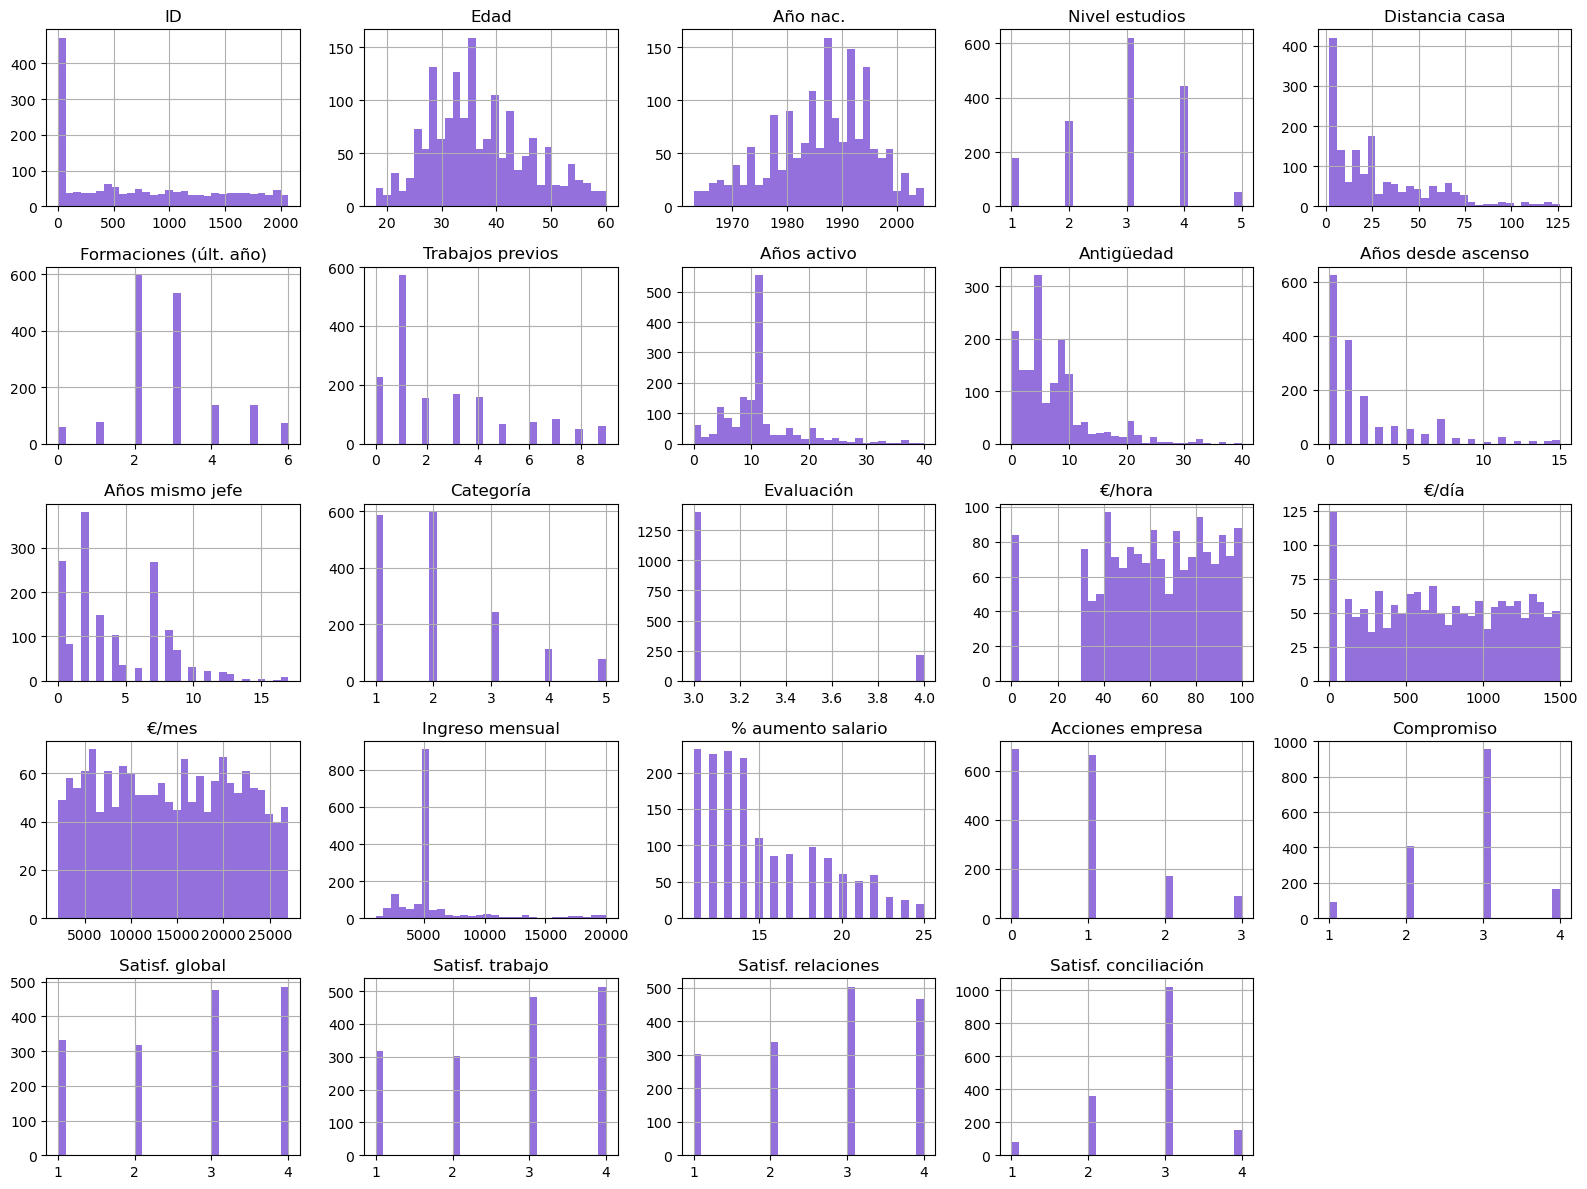

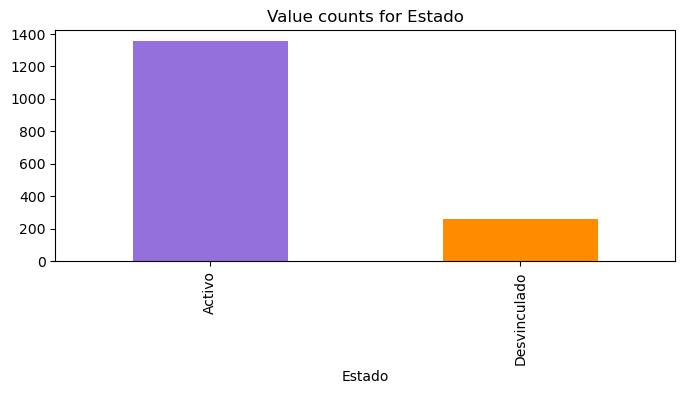

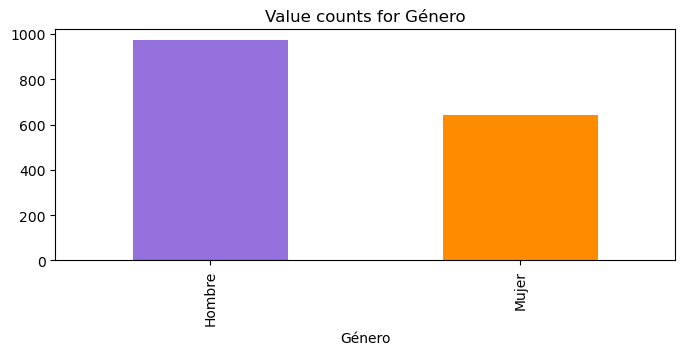

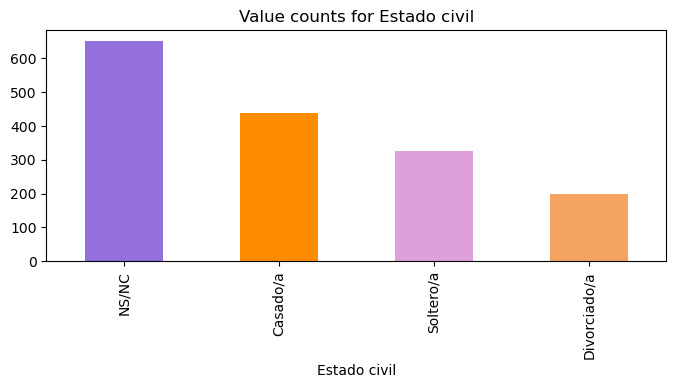

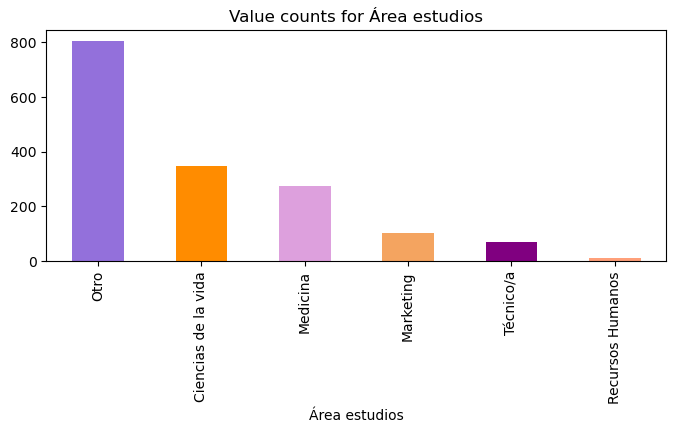

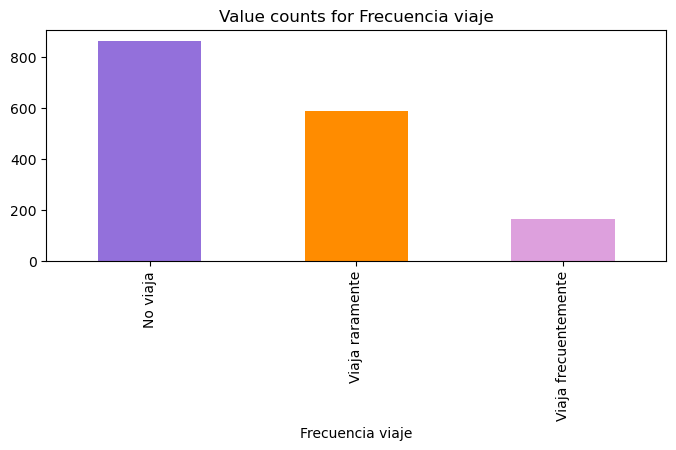

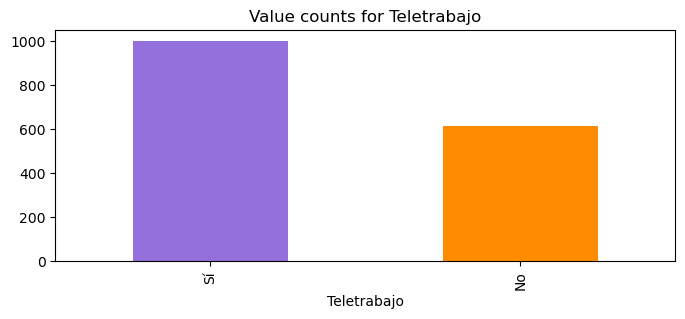

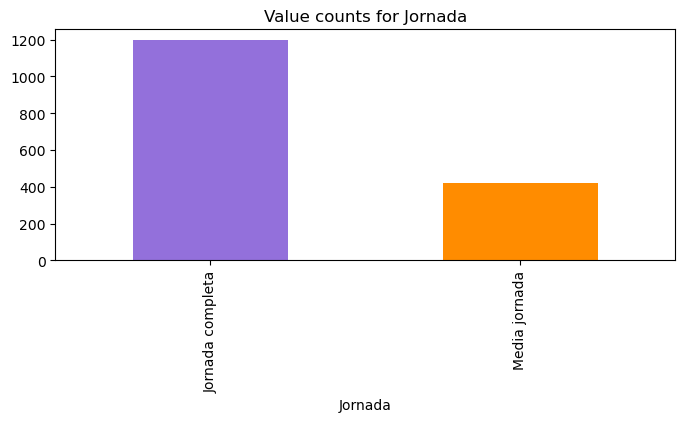

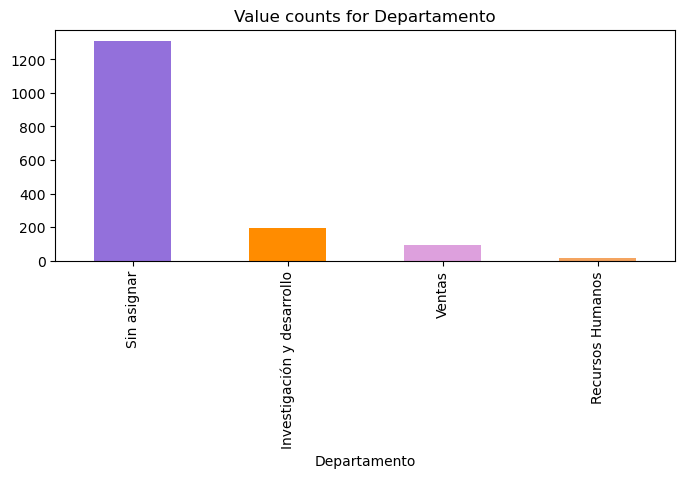

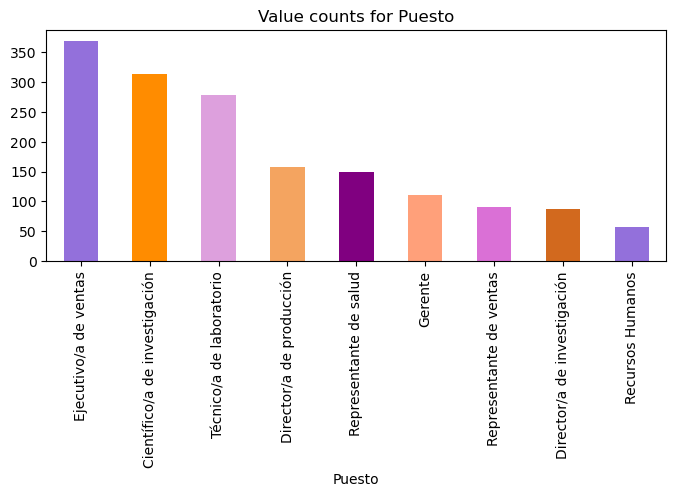

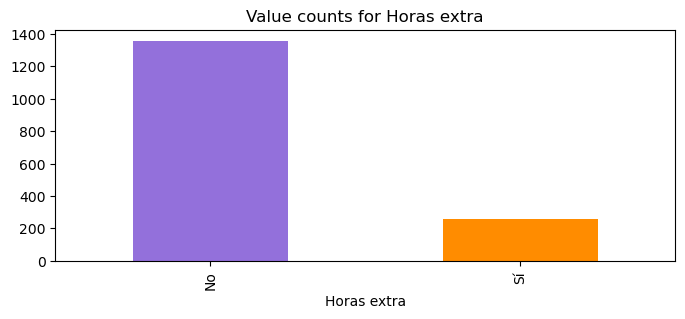

In [9]:
# Histograma para valorar las columnas numéricas
df.select_dtypes(include=[np.number]).hist(figsize=(16,12), bins=30, color = colores_proyecto[0])
# Selecciona todas las columnas numéricas y genera histogramas con 30 bins y color definido

plt.tight_layout()
# Ajusta automáticamente el espacio entre subgráficos para que no se solapen

plt.show()
# Muestra los histogramas en pantalla


# Barplots para valorar las columnas categóricas
cat_cols = df.select_dtypes(include=['object']).columns
# Extrae la lista de columnas categóricas (tipo object) del DataFrame

for col in cat_cols:
    plt.figure(figsize=(8,3))
    # Crea una nueva figura para cada gráfica con tamaño 8x3

    df[col].value_counts(dropna=False).plot(kind='bar', color = colores_proyecto)
    # Cuenta los valores únicos (incluyendo NaNs) y los representa en un gráfico de barras con el color definido

    plt.title(f'Value counts for {col}')
    # Añade un título al gráfico indicando la columna analizada

    plt.show()
    # Muestra el gráfico antes de pasar a la siguiente columna

###### **GRÁFICO 1:**

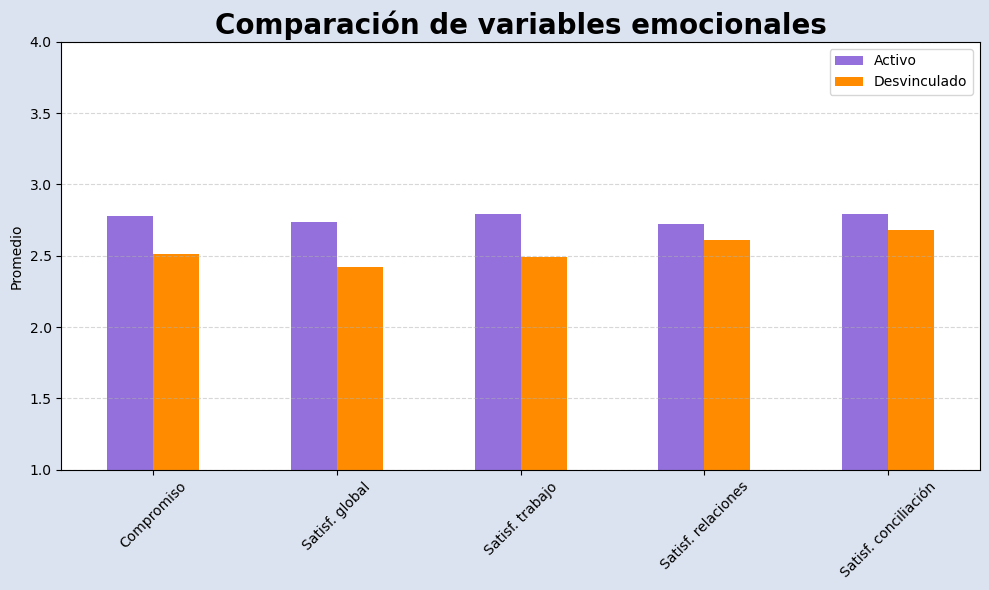

In [10]:
# Comparación de variables emocionales

variables_emocionales = ['Compromiso', 'Satisf. global', 'Satisf. trabajo', 'Satisf. relaciones','Satisf. conciliación']
# Lista con las columnas que contienen las variables emocionales a analizar

df_emocionales = (df.groupby('Estado')[variables_emocionales].mean()).round(2).T
# Agrupa el DataFrame por 'Estado', calcula la media de las variables emocionales,
# redondea a dos decimales y transpone para facilitar el plot

df_emocionales.columns = ["Activo", "Desvinculado"]
# Renombra las columnas resultantes para mayor claridad

ax = df_emocionales.plot(kind='bar', figsize=(10,6), color=colores_proyecto)
# Genera un gráfico de barras con tamaño 10x6 y colores definidos

fig = ax.get_figure()  # Obtiene el objeto figura desde el eje
# Cambia colores de fondo
fig.patch.set_facecolor('#dce3f0')       # Color del fondo general
ax.set_facecolor('#ffffff')              # Color del área del gráfico

plt.title("Comparación de variables emocionales",fontsize=20, fontweight='bold')
# Añade título al gráfico

plt.ylabel("Promedio")
# Etiqueta del eje Y indicando que los valores son promedios

plt.xticks(rotation=45)
# Rota las etiquetas del eje X 45 grados para mejor legibilidad

plt.legend()
# Muestra la leyenda para distinguir entre 'Activo' y 'Desvinculado'

plt.grid(axis='y', linestyle='--', alpha=0.5)
# Añade líneas de cuadrícula horizontales con estilo punteado y transparencia

plt.tight_layout()
# Ajusta el layout para evitar que los elementos se solapen

plt.ylim([1,4])
# Limita el eje Y entre 1 y 4 para mejorar la visualización

plt.show()
# Muestra el gráfico en pantalla

Conclusiones: 
  
  En la encuesta de satisfacción podemos l@s trabajador@s desvinculad@s se encontraban menos satisfechos con los diferentes ámbitos de su empresa que los empleados que continuan activos, generando por ello un compromiso menor

###### **GRÁFICO 2:**

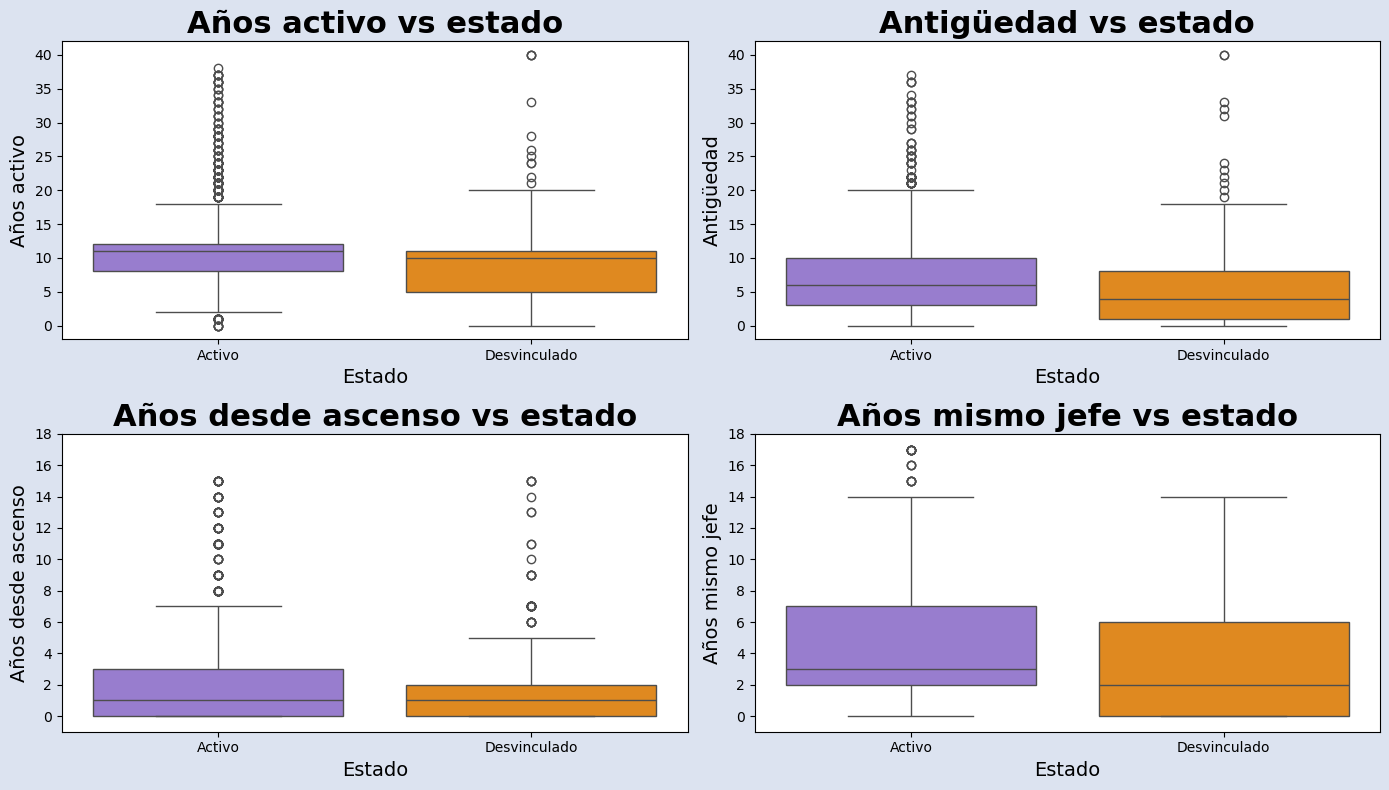

In [11]:
# Valoración historia laboral

fig, axes = plt.subplots(2, 2, figsize=(14, 8))  # altura aumentada para que no se solapen
# Crea una figura con una cuadrícula de 2 filas x 2 columnas para 4 gráficos
# El tamaño total es ancho 18 y alto 8 para evitar solapamientos

fig.patch.set_facecolor("#dce3f0")  # color general del fondo
axes = axes.flatten()  # convierte la matriz 2x2 en una lista de 4 ejes

# Cambiar el fondo de cada gráfico individual
for ax in axes:
    ax.set_facecolor("#ffffff")
# Cambia el color del fondo

columnas = ["Años activo", "Antigüedad", "Años desde ascenso", "Años mismo jefe"]
# Lista con los nombres de las columnas a graficar

axes = axes.flatten()  # convierte la matriz 2x2 en una lista de 4 ejes
# Facilita el acceso a cada subplot con índices 0 a 3

for i, col in enumerate(columnas):
    sns.boxplot(data=df, x="Estado", y=col, ax=axes[i], palette = colores_proyecto)
    # Genera un boxplot para la columna 'col' agrupado por 'Estado' en el subplot correspondiente

    axes[i].set_title(f'{col} vs estado',fontsize=22, fontweight='bold')
    # Establece el título del subplot

    axes[i].set_xlabel("Estado",fontsize=14)
    # Etiqueta del eje X para cada gráfico

    axes[i].set_ylabel(col,fontsize=14)
    # Etiqueta del eje Y con el nombre de la columna

# Establecer límites del eje Y solo para la segunda fila (índices 2 y 3)
for i in [2, 3]:
    axes[i].set_ylim(-1, 18)
    axes[i].yaxis.set_major_locator(MaxNLocator(integer=True)) # Utiliza una nueva librería de maxplotlib para convertir el dato del eje y en int

plt.tight_layout()
# Ajusta los espacios para que no se solapen los gráficos

plt.show()
# Muestra la figura con los cuatro boxplots

Conclusiones:
  
  En estas gráficas analizamos la vida laboral de los empleados en función de su estado actual. De estos datos podemos presumir que el empleado desvinculado lleva menos años en activo, tiene menos antigüedad en la empresa, no lleva mucho tiempo esperando un ascenso y lleva menos de 5 años trabajando con el mismo jefe. 

###### **GRÁFICO 3:**

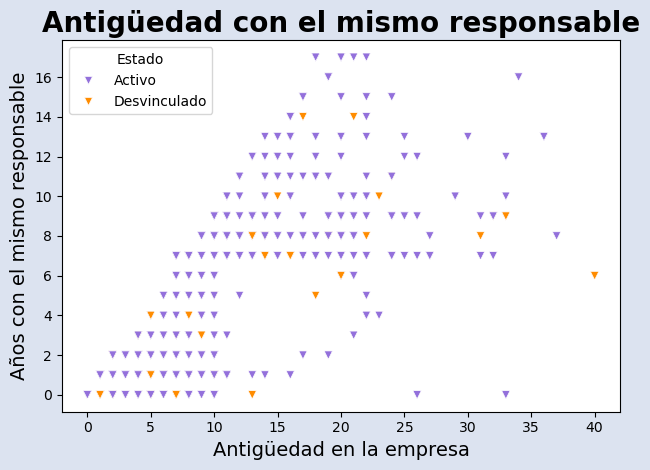

In [12]:
# Búsqueda de relación entre antigüedad, tiempo con el mismo responsable y estado

df_mod = df.copy()
# Copia el DataFrame original para evitar modificaciones directas
fig, ax = plt.subplots()
fig.patch.set_facecolor("#dce3f0")  # Cambia el color del fondo general
ax.set_facecolor("#ffffff") 

sns.scatterplot(x='Antigüedad', y='Años mismo jefe', data=df_mod, palette=colores_proyecto, marker='v', hue='Estado')
# Crea un gráfico de dispersión con:
# - eje X: 'Antigüedad'
# - eje Y: 'Años mismo jefe'
# - puntos con marcador en forma de 'v'
# - colores según el 'Estado' usando la paleta definida

plt.title("Antigüedad con el mismo responsable",fontsize=20, fontweight='bold')
# Título del gráfico

plt.ylabel("Años con el mismo responsable",fontsize=14)
# Etiqueta eje Y

plt.xlabel("Antigüedad en la empresa",fontsize=14)
# Etiqueta eje X

plt.legend(title='Estado')
# Muestra leyenda con título para distinguir los estados

plt.gca().yaxis.set_major_locator(MultipleLocator(2))
# Ajusta el eje Y para que las marcas principales estén cada 2 unidades

plt.tight_layout()
# Ajusta el layout para evitar solapamientos

plt.show()
# Muestra el gráfico

Conclusiones:
  
  En este gráfico analizamos la cantidad de tiempo que pasan los trabajadores en la empresa y el tiempo en el que se mantienen con el mismo responsable. Por el comportamiento de los datos, podemos intuir que tiene algo de relación pero este dato no parece afectar significativamente a la marcha de los trabajadores. 

###### **GRÁFICO 4:**

In [13]:
df1 = df.copy()
df1['Estado'] = df1['Estado'].replace({'Desvinculado': 1, 'Activo': 0}).astype(int)

<Figure size 800x500 with 0 Axes>

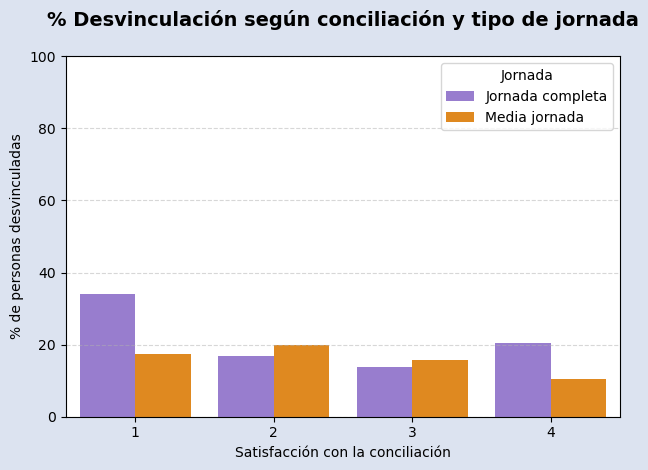

In [14]:
# Valoración de la conciliación respecto a la desvinculación

# Creamos una copia del DataFrame original para no modificar los datos base
df2 = df1.copy()

# Eliminamos las filas que tengan valores nulos en las columnas necesarias para el análisis
df2 = df2.dropna(subset=['Satisf. conciliación', 'Estado', 'Jornada'])

# Agrupamos por satisfacción con la conciliación y tipo de jornada,
# y calculamos la media de 'Estado' (donde 1 = desvinculado, 0 = activo)

df_grouped = df2.groupby(['Satisf. conciliación', 'Jornada'])['Estado'].mean().reset_index()

# Convertimos la proporción (0-1) a porcentaje (0-100)
df_grouped['% Desvinculados'] = df_grouped['Estado'] * 100

# Creamos la figura y el gráfico de barras
plt.figure(figsize=(8, 5))

fig, ax = plt.subplots()
fig.patch.set_facecolor("#dce3f0")  # Cambia el color del fondo general
ax.set_facecolor("#ffffff") 


sns.barplot(
    data=df_grouped,
    x='Satisf. conciliación',
    y='% Desvinculados',
    hue='Jornada',
    palette=colores_proyecto
)

# Etiquetas y título
plt.title('% Desvinculación según conciliación y tipo de jornada\n',fontsize=14, fontweight='bold')
plt.ylabel('% de personas desvinculadas')
plt.xlabel('Satisfacción con la conciliación')

# Límites del eje Y y estilo de rejilla
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Ajuste automático del diseño
plt.tight_layout()

# Mostramos el gráfico
plt.show()

Conclusiones:
  
  Aunque no vemos una tendencia muy clara, sí que parece que el mayor porcentaje de desvinculados tienen jornada completa valorando negativamente la conciliación. 

###### **GRÁFICO 5:**

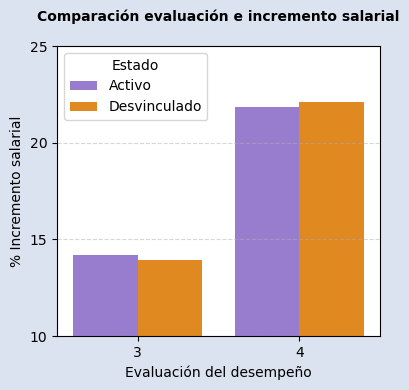

In [15]:
# Comparación evaluación desempeño e incremento salarial - no afecta a desvinculado

df_agrupado = df.groupby(["Evaluación", "Estado"], as_index=False)["% aumento salario"].mean()
# Agrupa el DataFrame por "Evaluación" y "Estado" y calcula la media del "% aumento salario" para cada grupo
# as_index=False mantiene las columnas "Evaluación" y "Estado" como columnas normales en el resultado

# Crear figura y eje
fig, ax = plt.subplots(figsize=(4, 4))  # 👈 así obtienes fig y ax directamente

# Cambiar colores de fondo
fig.patch.set_facecolor('#dce3f0')       # Fondo de toda la figura
ax.set_facecolor('#ffffff')              # Fondo del área del gráfico


sns.barplot(
    data=df_agrupado,             # Usa el DataFrame agrupado para graficar
    x="Evaluación",               # Eje X con la evaluación del desempeño
    y="% aumento salario",        # Eje Y con el porcentaje promedio de aumento salarial
    hue="Estado",                 # Divide las barras según el estado (ej. Activo o Desvinculado)
    palette= colores_proyecto     # Usa la paleta de colores personalizada
)

# Estética
plt.title("Comparación evaluación e incremento salarial\n",fontsize=10, fontweight='bold')  # Título del gráfico
plt.ylabel("% Incremento salarial")                                  # Etiqueta eje Y
plt.xlabel("Evaluación del desempeño")                              # Etiqueta eje X
plt.ylim(10, 25)                                                    # Limita eje Y entre 10 y 25 para mejor visualización
plt.grid(axis='y', linestyle='--', alpha=0.5)                      # Añade líneas de cuadrícula horizontales con estilo punteado y transparencia
plt.legend(title="Estado")                                         # Muestra leyenda con título "Estado"
plt.gca().yaxis.set_major_locator(MultipleLocator(5))              # Configura que las marcas del eje Y sean cada 5 unidades
plt.tight_layout()                                                 # Ajusta el layout para evitar solapamientos
plt.show()                                                        # Muestra el gráfico

Conclusiones:
  
  De este gráfico sacamos que la empresa está reconociendo económicamente a los trabajadores en función de su desempeño y esto no parece suponer un motivo de desvinculación. 


##### **Perfil desvinculado:**


###### **GRÁFICO 6:**

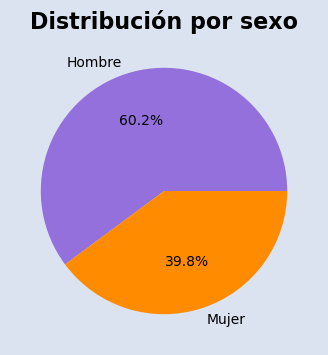

In [16]:
# En función del género:
# Calcula el porcentaje que representa cada género en todo el DataFrame
porcentaje_por_genero = df['Género'].value_counts(normalize=True) * 100


# Crear figura y eje
fig, _ = plt.subplots(figsize=(4, 4))  

# Cambiar colores de fondo
fig.patch.set_facecolor('#dce3f0')       # Fondo de toda la figura

# Dibuja un gráfico de pastel con los porcentajes, etiquetas y colores personalizados
plt.pie(
    porcentaje_por_genero,                    # Valores a mostrar
    labels=porcentaje_por_genero.index,      # Etiquetas de cada sector (géneros)
    autopct='%1.1f%%',                       # Mostrar porcentaje con un decimal
    colors=colores_proyecto                   # Paleta de colores definida previamente
)

# Título del gráfico
plt.title("Distribución por sexo",fontsize=16, fontweight='bold')

# Muestra el gráfico
plt.show()

Conclusiones:

  Tras analizar el género de los trabajadores, vemos que es mayoritariamente masculina con un 60%

###### **GRÁFICO 7:**

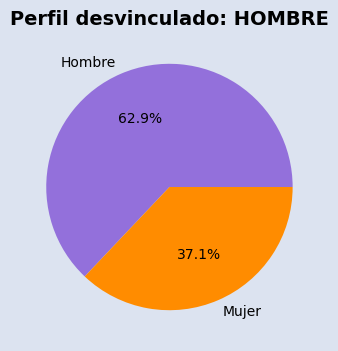

In [17]:
# En función del género:
# Filtrar el DataFrame para obtener solo los empleados desvinculados
df_filtrado = df[df['Estado'] == "Desvinculado"]
# Calcula el porcentaje que representa cada género dentro de los desvinculados
porcentaje_por_genero = df_filtrado['Género'].value_counts(normalize=True) * 100
# Crea una figura para el gráfico circular con tamaño 4x4 pulgadas
# Crear figura y eje
fig, _ = plt.subplots(figsize=(4, 4))  

# Cambiar colores de fondo
fig.patch.set_facecolor('#dce3f0')       # Fondo de toda la figura
# Dibuja un gráfico de pastel con los porcentajes, etiquetas y colores personalizados
plt.pie(porcentaje_por_genero, labels=porcentaje_por_genero.index, autopct='%1.1f%%', colors=colores_proyecto)
# Título del gráfico
plt.title("Perfil desvinculado: HOMBRE",fontsize=14, fontweight='bold')
# Muestra el gráfico
plt.show()

Conclusiones:
 
  Si hacemos zoom a los trabajadores desvinculados, vemos que el porcentaje se mantiene, siendo en un 62% de las personas que dejan la empresa, varones. 

###### **GRÁFICO 8:**

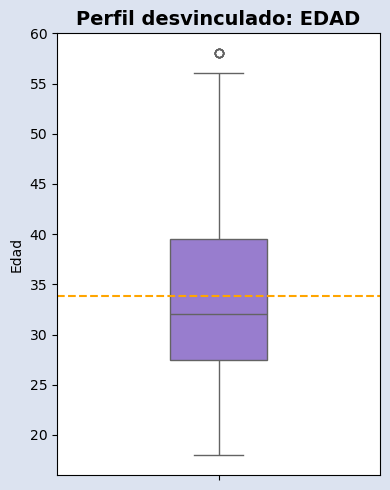

In [18]:
# En función de la edad:
# Filtra el DataFrame para quedarse solo con empleados desvinculados
df_filtrado = df[df['Estado'] == "Desvinculado"]

# Calcula la media de la edad en este grupo filtrado
media_edad = df_filtrado["Edad"].mean()

# Crear figura y eje
fig, ax = plt.subplots(figsize=(4, 5))   

# Cambiar colores de fondo
fig.patch.set_facecolor('#dce3f0')       # Fondo de toda la figura
ax.set_facecolor('#ffffff')              # Fondo del área del gráfico

# Dibuja un boxplot para mostrar la distribución de edades del grupo filtrado
sns.boxplot(y=df_filtrado['Edad'], palette=colores_proyecto, width=0.3)

# Añade una línea horizontal que marque la media de la edad
plt.axhline(media_edad, color='orange', linestyle='--', linewidth=1.5, label=f'Media: {media_edad:.1f} años')

# Añade un título descriptivo al gráfico
plt.title("Perfil desvinculado: EDAD",fontsize=14, fontweight='bold')

# Etiqueta el eje Y
plt.ylabel("Edad")

# Ajusta el layout para evitar que se solapen elementos del gráfico
plt.tight_layout()

# Muestra el gráfico en pantalla
plt.show()

Conclusiones:
  
  Por lo que se podría haber entendido en consultas anteriores parecía que el perfil del trabajador desvinculado era de corta edad por su menor trayectoria laboral pero la mediana y media de edad de este grupo de trabajadores se establece entre 33 y 34 años. 

###### **GRÁFICO 9:**

Text(0.5, 0, 'Variables')

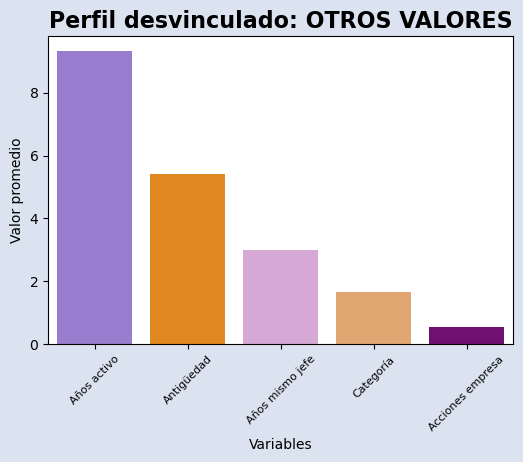

In [19]:
# Revisión otros valores medios del trabajador desvinculado

# Filtrar empleados desvinculados (Estado == 1) y calcular estadísticas descriptivas para columnas específicas
df1_stats = df1.query("Estado == 1")[['Años activo', 'Antigüedad', 'Años mismo jefe', 'Categoría', 'Acciones empresa']].describe().T

# Crear figura y eje
fig, ax = plt.subplots(figsize=(6, 4))   

# Cambiar colores de fondo
fig.patch.set_facecolor('#dce3f0')       # Fondo de toda la figura
ax.set_facecolor('#ffffff')              # Fondo del área del gráfico

# Generar un gráfico de barras con los valores medios (mean) de las variables seleccionadas
sns.barplot(x=df1_stats.index, y=df1_stats["mean"], palette=colores_proyecto)

# Rotar las etiquetas del eje x 90 grados, alineadas a la derecha y con tamaño de fuente 8
plt.xticks(rotation=45, ha='right', fontsize=8)

# Ajustar las etiquetas del eje x para que estén centradas en cada barra
x_labels = df1_stats.index
plt.xticks(ticks=range(len(x_labels)), labels=x_labels, ha='center')

# Titulo
plt.title("Perfil desvinculado: OTROS VALORES",fontsize=16, fontweight='bold')

# Etiqueta del eje y
plt.ylabel("Valor promedio")

# Etiqueta del eje x
plt.xlabel("Variables")

Conclusiones:
  
  Con esta tabla queremos seguir delimitando el perfil del trabajador desvinculado, que lleva de media 9 años en activo, 7 años en la propia empresa, 3 años con el mismo jefe, 2 años con la misma categoría y no parece tener mucho acceso a las acciones de la empresa. 

##### **Factores que influyen en la desvinculación:**

###### **GRÁFICO 10:**

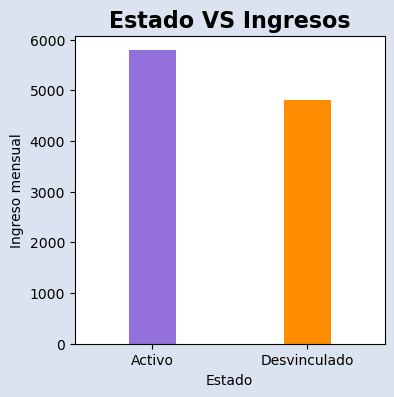

In [20]:
# INGRESOS no parece afectar a la desvinculación.

# Agrupar el DataFrame por 'Estado' y calcular la media del 'Ingreso mensual', redondeando a 2 decimales
df_ingreso = df.groupby('Estado')['Ingreso mensual'].mean().round(2)

# Crear un array con posiciones para cada barra (ejemplo: [0, 1] si hay dos estados)
x = np.arange(len(df_ingreso))

# Guardar las etiquetas (estados) para el eje x
etiquetas = df_ingreso.index

# Guardar los valores promedio de ingreso para las barras
valores = df_ingreso.values

# Crear figura y eje
fig, ax = plt.subplots(figsize=(4, 4))   

# Cambiar colores de fondo
fig.patch.set_facecolor('#dce3f0')       # Fondo de toda la figura
ax.set_facecolor('#ffffff')              # Fondo del área del gráfico

# Graficar barras usando las posiciones x, alturas valores, colores definidos y ancho 0.3
plt.bar(x=x, height=valores, color=colores_proyecto, width=0.3)

# Poner las etiquetas en el eje x en las posiciones de x
plt.xticks(ticks=x, labels=etiquetas)

# Ajustar límites del eje x para centrar las barras en su posición
plt.xlim(-0.5, len(x) - 0.5)

# Etiqueta del eje x
plt.xlabel('Estado')

# Etiqueta del eje y
plt.ylabel('Ingreso mensual')

# Título del gráfico
plt.title('Estado VS Ingresos',fontsize=16, fontweight='bold')

# Mostrar gráfico
plt.show()

Conclusiones:
  
  En cuanto a los ingresos, no vemos mucha diferencia entre los trabajadores activos y los desvinculados, siendo el de estos últimos algo menor pero también debemos recordar que suelen llevar menos tiempo en la empresa así que resulta más complicado que suban de categoría y de salario, en consecuencia. 

###### **GRÁFICO 11:**

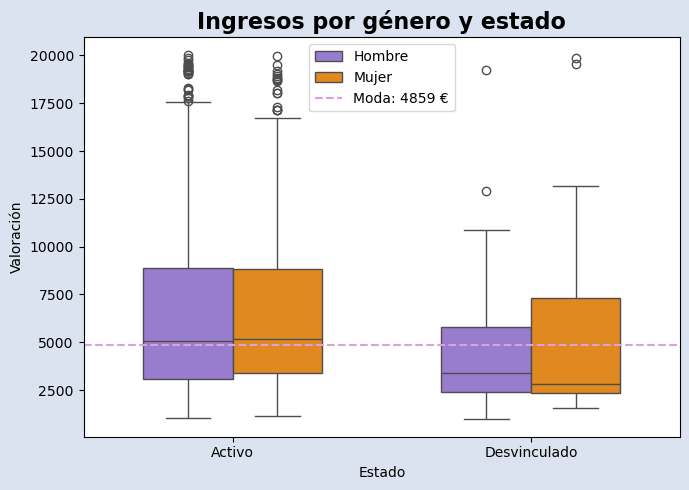

In [21]:
# Calcular la moda del ingreso mensual (valor más frecuente)
moda = df["Ingreso mensual"].mode().iloc[0]

# Filtrar el DataFrame para eliminar las filas donde el ingreso mensual es igual a la moda
df_ingresos = df[df["Ingreso mensual"] != moda]

# Crear figura y eje
fig, ax = plt.subplots(figsize=(7, 5))   

# Cambiar colores de fondo
fig.patch.set_facecolor('#dce3f0')       # Fondo de toda la figura
ax.set_facecolor('#ffffff')              # Fondo del área del gráfico

# Crear un boxplot para ingreso mensual, separado por Estado y con hue por Género
sns.boxplot(
    x='Estado', y='Ingreso mensual', hue='Género', data=df_ingresos, 
    palette=colores_proyecto, legend=True, dodge=True, width=0.6
)
# Línea horizontal que marca la moda del ingreso mensual con estilo punteado y etiqueta
plt.axhline(moda, color="plum", linestyle='--', linewidth=1.5, label=f'Moda: {moda:.0f} €')

# Título del gráfico
plt.title("Ingresos por género y estado",fontsize=16, fontweight='bold')

# Etiqueta eje x
plt.xlabel('Estado')

# Etiqueta eje y
plt.ylabel('Valoración')

# Ajusta el diseño para que no se solapen elementos
plt.tight_layout()

# Mostrar leyenda para la línea de la moda
plt.legend()

# Mostrar el gráfico
plt.show()

Conclusiones:
  
  Tratando de nuevo el tema de los ingresos, comprobamos si las desvinculaciones puedan deberse a que se sientan discriminados por sexo. Efectivamente, podemos ver que la mediana de estos trabajadores se encuentra muy por debajo de la media de la empresa. 

###### **GRÁFICO 12:**

<Axes: >

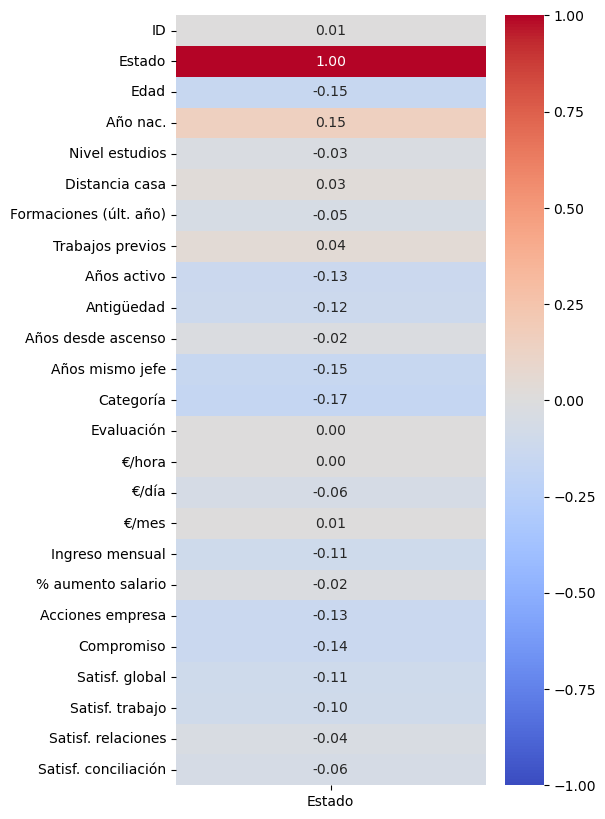

In [22]:
# Calcular la correlación entre variables numéricas y la columna 'Estado'
df_correlation = df1.select_dtypes(include="number").corr()[["Estado"]]

# Mostrar la tabla de correlaciones calculada
df_correlation

# Crear figura para el heatmap con tamaño 5x10 pulgadas
plt.figure(figsize=(5, 10))

# Crear un mapa de calor de las correlaciones con anotaciones numéricas
sns.heatmap(
    df_correlation,        # Datos de correlación
    annot=True,            # Mostrar valores numéricos en cada celda
    fmt=".2f",             # Formato de números con 2 decimales
    cmap="coolwarm",       # Paleta de colores (rojo-azul)
    vmax=1,                # Valor máximo de la escala (correlación máxima)
    vmin=-1                # Valor mínimo de la escala (correlación mínima)
)

###### **GRÁFICO 13:**

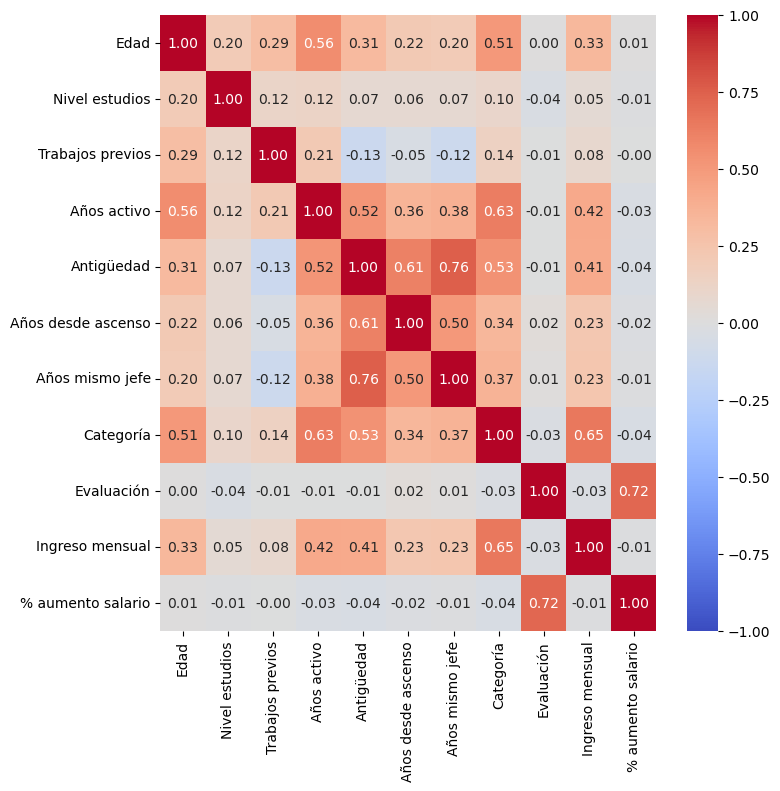

In [23]:
# MAPA de calor para valorar las variables numéricas que pueden tener relación

df_mapacalor = df[['Edad', 'Nivel estudios', 'Trabajos previos', 'Años activo',
                   'Antigüedad', 'Años desde ascenso', 'Años mismo jefe', 'Categoría',
                   'Evaluación', 'Ingreso mensual', '% aumento salario']]
# Selecciona las columnas numéricas relevantes para analizar la correlación

valores = df_mapacalor.columns
# Guarda los nombres de las columnas seleccionadas

df_correlation = df[valores].corr()
# Calcula la matriz de correlación entre esas columnas

plt.figure(figsize = (8, 8))
# Crea una figura cuadrada de tamaño 8x8 pulgadas

sns.heatmap(df_correlation,  # Dibuja el mapa de calor con las correlaciones
            annot = True,    # Muestra los valores numéricos en cada celda
            fmt = ".2f",     # Formato de los números con 2 decimales
            cmap = "coolwarm",  # Paleta de colores que va de frío a cálido
            vmax = 1,        # Valor máximo en el gradiente de color
            vmin = -1,       # Valor mínimo en el gradiente de color
            );
# La visualización permite identificar relaciones positivas o negativas fuertes entre variables

### **FASE 4 BONUS: Diseño de base de datos e insertar los datos en SQL.**

In [59]:
# LOAD: Crear la base de datos y cargar los datos
# =====================

# Configuración de la base de datos
host = '127.0.0.1'
user = 'root'
password = 'AlumnaAdalab'
database = 'worker_database'

def create_db():
    # Conectar a MySQL usando pymysql
    connection = pymysql.connect(
        host=host,
        user=user,
        password=password
    )

    # Crear un cursor
    cursor = connection.cursor()

    # Crear una base de datos si no existe
    cursor.execute(f"CREATE DATABASE IF NOT EXISTS {database}")
    print("Base de Datos creada exitosamente.")

    # Cerrar la conexión
    connection.close()

def load_data(table_name, data):
    print(f"Cargando datos en la tabla {table_name}...")

    # Crear conexión a MySQL usando SQLAlchemy
    engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')

    # Insertar datos desde el DataFrame en MySQL
    data.to_sql(table_name, con=engine, if_exists='append', index=False)
    print(f"Datos insertados en la tabla {table_name} exitosamente.")

In [60]:
# Crear schema en SQL
create_db()

Base de Datos creada exitosamente.


In [61]:
# Cargamos los datos
load_data('Employees', df)

Cargando datos en la tabla Employees...
Datos insertados en la tabla Employees exitosamente.
